Packages
=================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import OrderedDict

Import dataset
========================

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()

we separate X\_train\_numpy and X\_test\_numpy into chunks, the batch\_size = 200 

In [ ]:
X_train_chunks = int(X_train_numpy.shape[0] / 200)
X_test_chunks = int(X_test_numpy.shape[0] / 200)

(CLASS) MaskedLinear
====================
add mask opon the weights.  
The weigths is generated by nn.Linear model  
It takes mask as an input whose shape is in_features $ \times $out_features, mask is store in buffer so that it will never be updated in each optim.step


In [ ]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        # self.register_buffer('mask', mask.T) # will not update when optimizaiton
        self.mask = mask.T.cuda()
        self.mask.requires_grad = False
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(f"ml is {x.size(), self.weight.size(), self.mask.size(), self.bias.size()}")
        return F.linear(x, self.weight * self.mask,self.bias)

test it! check the dimension  


In [ ]:
mask_test = torch.tensor([[1., 0.], [0., 1.], [1., 1.]])
x_test = torch.tensor([[1., 1., 1.], [1., 1., 1.]]).cuda()
M = MaskedLinear(3, 2, mask_test).cuda()
M.weight, M.mask, M.bias, M.forward(x_test)

(Parameter containing:
 tensor([[ 0.5307, -0.4578, -0.4732],
         [-0.4488,  0.3031, -0.3973]], device='cuda:0', requires_grad=True),
 tensor([[1., 0., 1.],
         [0., 1., 1.]], device='cuda:0'),
 Parameter containing:
 tensor([ 0.3613, -0.0868], device='cuda:0', requires_grad=True),
 tensor([[ 0.4188, -0.1810],
         [ 0.4188, -0.1810]], device='cuda:0', grad_fn=<AddmmBackward>))

MADE
======================
First, we need to generate masks  
The first thing is to use m list, we designate input shape and hidden layers.  
the m list is composed of three parts, the beginning, the middles and the ending.  
The beginning and the ending upon to the input shape and the middles depend on the hidden_layers

parameters
-------------------
We set parameters, including input\_shape, hidden\_layers and d.

In [ ]:
# parameters
input_shape_test = 28*28
hidden_layers_test = [28*28, 28*28]
d_test = 1

create m
---------------
In the experiment, we input img = [1, 28, 28], so we design the MADE in this way

In [ ]:
# in_features and out_features
in_features = input_shape_test * d_test
out_features = input_shape_test * d_test
layers = [in_features] + hidden_layers_test + [out_features]

m = []
m = [torch.arange(input_shape_test).repeat(d_test,)] + \
    [torch.arange(l) for l in hidden_layers_test] + \
    [torch.arange(input_shape_test).repeat(d_test,)]
# m

create masks
-------------------
Then we generate the mask depends on the neighboring two components of m.

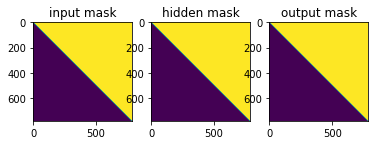

In [ ]:
masks = []
for i in range(len(m)-2):
    masks.append((m[i][:,None] <= m[i+1][None, :]).int())
masks.append((m[-2][:,None] < m[-1][None,:]).int())

fig, axes = plt.subplots(1, 3)
axes[0].imshow(masks[0])
axes[0].set_title("input mask")
axes[1].imshow(masks[1])
axes[1].set_title("hidden mask")
axes[2].imshow(masks[2])
axes[2].set_title("output mask")
plt.show()

create flow
-----------------
assembling the sequence, actually create matrix across two neighboring layers

In [ ]:
flow = []
h1 = layers[:-1]
h2 = layers[1:]

for idx, (hh1, hh2) in enumerate(zip(h1, h2)):
    flow.append(MaskedLinear(hh1, hh2, masks[idx]))
    flow.append(nn.ReLU())
flow.pop()
flow

[MaskedLinear(in_features=784, out_features=784, bias=True),
 ReLU(),
 MaskedLinear(in_features=784, out_features=784, bias=True),
 ReLU(),
 MaskedLinear(in_features=784, out_features=784, bias=True)]

**(CLASS)** create MADE class
--------------------
In the forward, the x.size() = [batch\_size, img\_height, img\_width]

In [ ]:
class MADE(nn.Module):
    def __init__(self, input_shape, hidden_layers, d, bias=True):
        super(MADE, self).__init__()
        self.input_shape = input_shape
        self.hidden_layers = hidden_layers
        self.d = d
        self.bias =bias

        # create m
        self.in_features = input_shape * d
        self.out_features = input_shape * d
        self.layers = [self.in_features] + self.hidden_layers + [self.out_features]

        self.m = []
        self.m = [torch.arange(self.input_shape).repeat(d,)] + \
                 [torch.arange(l) for l in self.hidden_layers] + \
                 [torch.arange(self.input_shape).repeat(d,)]

        # create masks
        self.masks = []
        for i in range(len(self.m)-2):
            self.masks.append((self.m[i][:,None] <= self.m[i+1][None, :]).int())
        self.masks.append((self.m[-2][:,None] < self.m[-1][None,:]).int())

        # create flow
        self.flow = OrderedDict()
        h1 = self.layers[:-1]
        h2 = self.layers[1:]

        for idx, (hh1, hh2) in enumerate(zip(h1, h2)):
            self.flow['maskedlinear_'+str(idx)] = MaskedLinear(hh1, hh2, self.masks[idx])
            self.flow['act_'+str(idx)] = nn.ReLU()
        self.flow.popitem('act_'+str(idx))

        self.flow = nn.Sequential(self.flow)
        # print(f"flow is {self.flow}")
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.flow(x)

test the MADE class
-------------------------
We use one or a batch of image(s) from the MNIST to test it.  
We test MaskedLinear first then combine them together

In [ ]:
batch_size = 3
mask_select = masks[0]
x_test = torch.div(torch.from_numpy(X_train_numpy[0:batch_size, 0:28, 0:28])\
                   .type(torch.FloatTensor), 255).cuda()
lm_test = MaskedLinear(in_features=mask_select.size()[0], 
                       out_features=mask_select.size()[1], 
                       mask = mask_select, bias=True).cuda()
lm_test(x_test).size()

# masks[0].size()

torch.Size([3, 784])

In [ ]:
made_test = MADE(input_shape_test, hidden_layers_test, d_test).cuda()
# print(made_test.flow)
# print(x_test.size())
made_test(x_test).size() # (batch_size, output_size) output_size always equals to input_size

flow is Sequential(
  (maskedlinear_0): MaskedLinear(in_features=784, out_features=784, bias=True)
  (act_0): ReLU()
  (maskedlinear_1): MaskedLinear(in_features=784, out_features=784, bias=True)
  (act_1): ReLU()
  (maskedlinear_2): MaskedLinear(in_features=784, out_features=784, bias=True)
)
in made
torch.Size([3, 784])


torch.Size([3, 784])

Train (Blind Generation)
===============
the input\_size = img\_height * img\_width  
batch_size = 200  
Here we feed **all train dataset** to train our model instead of labelize the dataset

100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


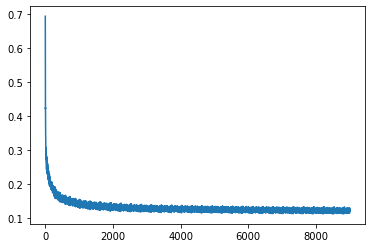

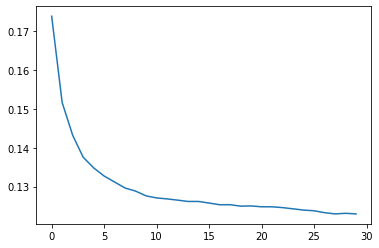

In [ ]:
# parameters
batch_train_size = 200
batch_test_size = 33
input_shape = 28*28
hidden_layers = [28*28, 28*28]
d = 1

X_train_chunks = int(X_train_numpy.shape[0] / batch_train_size)
X_test_chunks = int(X_test_numpy.shape[0] / batch_test_size)
# made = MADE(28*28, [300, 400], 1).cuda()
made = MADE(input_shape, hidden_layers, d).cuda()
optimizer = Adam(made.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
train_loss_hist = []
valid_loss_hist = []
epochs = 30

for epoch in tqdm(range(epochs)):
    for i in range(X_train_chunks):
        x = torch.div(torch.from_numpy(X_train_numpy[i*batch_train_size:(i+1)*batch_train_size, 
                                                     0:28, 0:28])\
                    .type(torch.FloatTensor), 255).view(batch_train_size, -1).cuda()
        pred = made(x)
        loss = criterion(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_hist.append(loss)

    valid_loss = 0
    for i in range(X_train_chunks):
        x = torch.div(torch.from_numpy(X_test_numpy[i*batch_test_size:(i+1)*batch_test_size, 0:28, 0:28])\
                    .type(torch.FloatTensor), 255).view(batch_test_size, -1).cuda()
        with torch.no_grad():
            pred = made(x)
        loss = criterion(pred, x)
        valid_loss += loss

    valid_loss_hist.append(valid_loss/X_train_chunks)

plt.plot(train_loss_hist)
plt.show()
plt.plot(valid_loss_hist)




Generate and Plot
======================

Let's first feed images from test dataset and plots the feed images  
**You can change the idd to get more options**

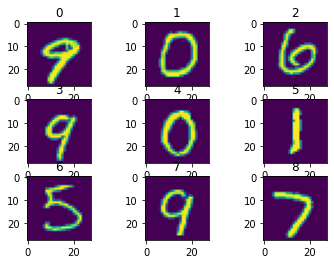

In [ ]:
# idd can be modified
idd = 1
num_samples = 9
image_size = 28*28
samples = torch.div(torch.from_numpy(X_test_numpy[idd*num_samples:(idd+1)*num_samples, 0:28, 0:28])\
                    .type(torch.FloatTensor), 255).view(num_samples, -1).cuda()

with torch.no_grad():
    out = made(samples).cuda()
out = torch.sigmoid(out)

############# plot input images from test dataset ##############
fig, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(samples[i*3 + j].view(28,28).cpu())
        axes[i, j].set_title(f"{i*3 + j}")
plt.show()


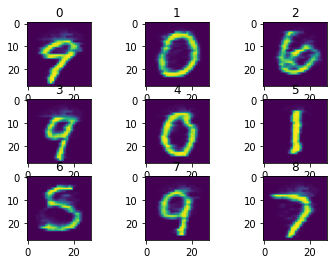

In [ ]:
############# plot output images ##############
fig, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(out[i*3 + j].view(28,28).cpu())
        axes[i, j].set_title(f"{i*3 + j}")
plt.show()